In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import csv
import random
from skimage.transform import rotate
import joblib

# Load images
Loads images from dowloaded file, reizes, alters and saves two versions: 1. RGB version, 2. Grayscale version

In [3]:
#Courtesy of GTSRB website

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader)  # skip header 
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels


I,L = readTrafficSigns("E:\\Emerging AI Tech and Sustainability\\GTSRB_Data\\Final_Training\\images")

In [4]:
print("Total images:", len(I))
print("Total labels:", len(L))
if(len(I)==len(L)):
    print("No mismatches detected")

Total images: 39209
Total labels: 39209
No mismatches detected


Data augmentation is a technique that helps to increment the training data by creating
new images with the existing data5. This technique is important because the training
data becomes more balanced, so the model can classify better, and it will also help to
prevent over-fitting when training. Image augmentation can be done in several forms,
by randomly flipping the image, rotating the image, stretching the image, zooming the
image, or cropping the image. - https://www.datacamp.com/tutorial/complete-guide-data-augmentation
- 

In [5]:
def augment_with_rotation(images, labels, rotation_range=(-15, 15), n=1): #Creates n altered copies of each image, start with 1 for now
    augmented_images = []
    augmented_labels = []
    
    for image, label in zip(images, labels):
        augmented_images.append(image)
        augmented_labels.append(label)
        
        for _ in range(n):
            angle = random.uniform(rotation_range[0], rotation_range[1])
            rotated = rotate(image, angle, mode='edge')  #helps with border artifacts
            augmented_images.append((rotated * 255).astype(np.uint8))  # Convert back to 0-255 range
            augmented_labels.append(label)
    
    return augmented_images, augmented_labels
augmented_I, augmented_L = augment_with_rotation(I, L, rotation_range=(-10, 10), n=1)

In [6]:
print(f"Original dataset size: {len(I)}")
print(f"Augmented dataset size: {len(augmented_I)}")

Original dataset size: 39209
Augmented dataset size: 78418


In [7]:
#resize to 32x32
augmented_I = [cv2.resize(img, (32, 32)) for img in augmented_I]

In [9]:
augmented_I = np.array(augmented_I)
augmented_I_RGB = []
augmented_I_Gray = []
for img in augmented_I:
    #Convert to grayscale (from BGR as thats what cv2 uses)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    augmented_I_Gray.append(gray_img)
    augmented_I_RGB.append(img)  

augmented_I_RGB = np.array(augmented_I_RGB)  # Shape: (N, 32, 32, 3) in BGR
augmented_I_Gray = np.array(augmented_I_Gray)  # Shape: (N, 32, 32)

#Labels remain unchanged
print(f"RGB images shape: {augmented_I_RGB.shape}")
print(f"Grayscale images shape: {augmented_I_Gray.shape}")
print(f"Labels count: {len(augmented_L)}")  # Should match N

RGB images shape: (78418, 32, 32, 3)
Grayscale images shape: (78418, 32, 32)
Labels count: 78418


In [11]:
augmented_I_Gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in augmented_I_RGB])

In [13]:
class_names = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection", 12: "Priority road", 13: "Yield",
    14: "Stop", 15: "No vehicles", 16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry", 18: "General caution", 19: "Dangerous curve to the left",
    20: "Dangerous curve to the right", 21: "Double curve", 22: "Bumpy road",
    23: "Slippery road", 24: "Road narrows on the right", 25: "Road work",
    26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead",
    34: "Turn left ahead", 35: "Ahead only", 36: "Go straight or right",
    37: "Go straight or left", 38: "Keep right", 39: "Keep left",
    40: "Roundabout mandatory", 41: "End of no passing",
    42: "End of no passing for vehicles over 3.5 metric tons"
}

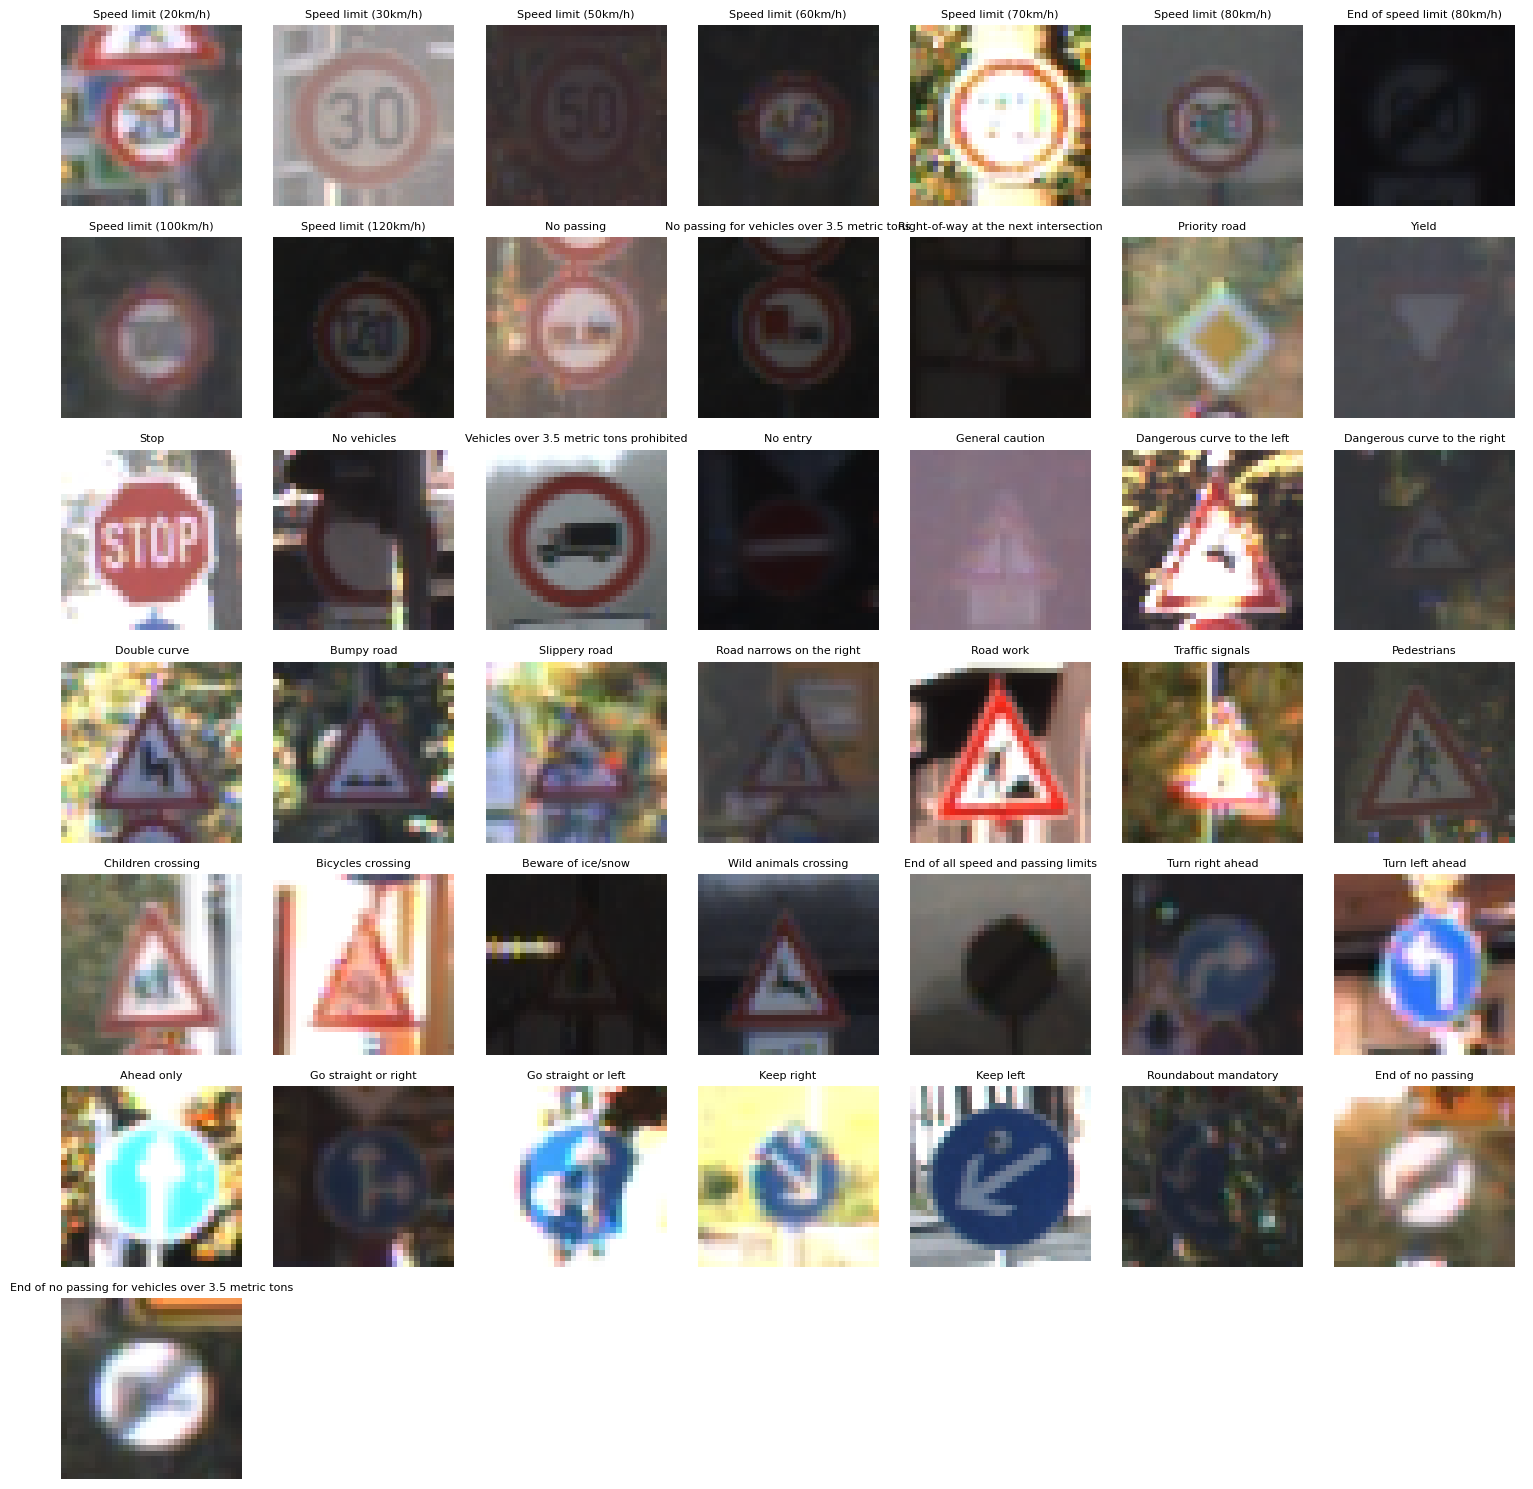

In [14]:
images_per_class = {}

#Loop through the list of labels and images (I, L) 
for image, label in zip(augmented_I_RGB, augmented_L):
                                        #Stores the first image in each class
    if label not in images_per_class:
        images_per_class[label] = image

fig, axes = plt.subplots(7, 7, figsize=(15, 15))  
axes = axes.flatten()  

#Loop through the images_per_class dictionary and plot the images
for idx, (label, image) in enumerate(images_per_class.items()):
    axes[idx].imshow(image) 
    axes[idx].set_title(class_names[int(label)], fontsize=8)  
    axes[idx].axis('off')  

for i in range(len(images_per_class), len(axes)):
    axes[i].axis('off')

plt.tight_layout() 
plt.show()

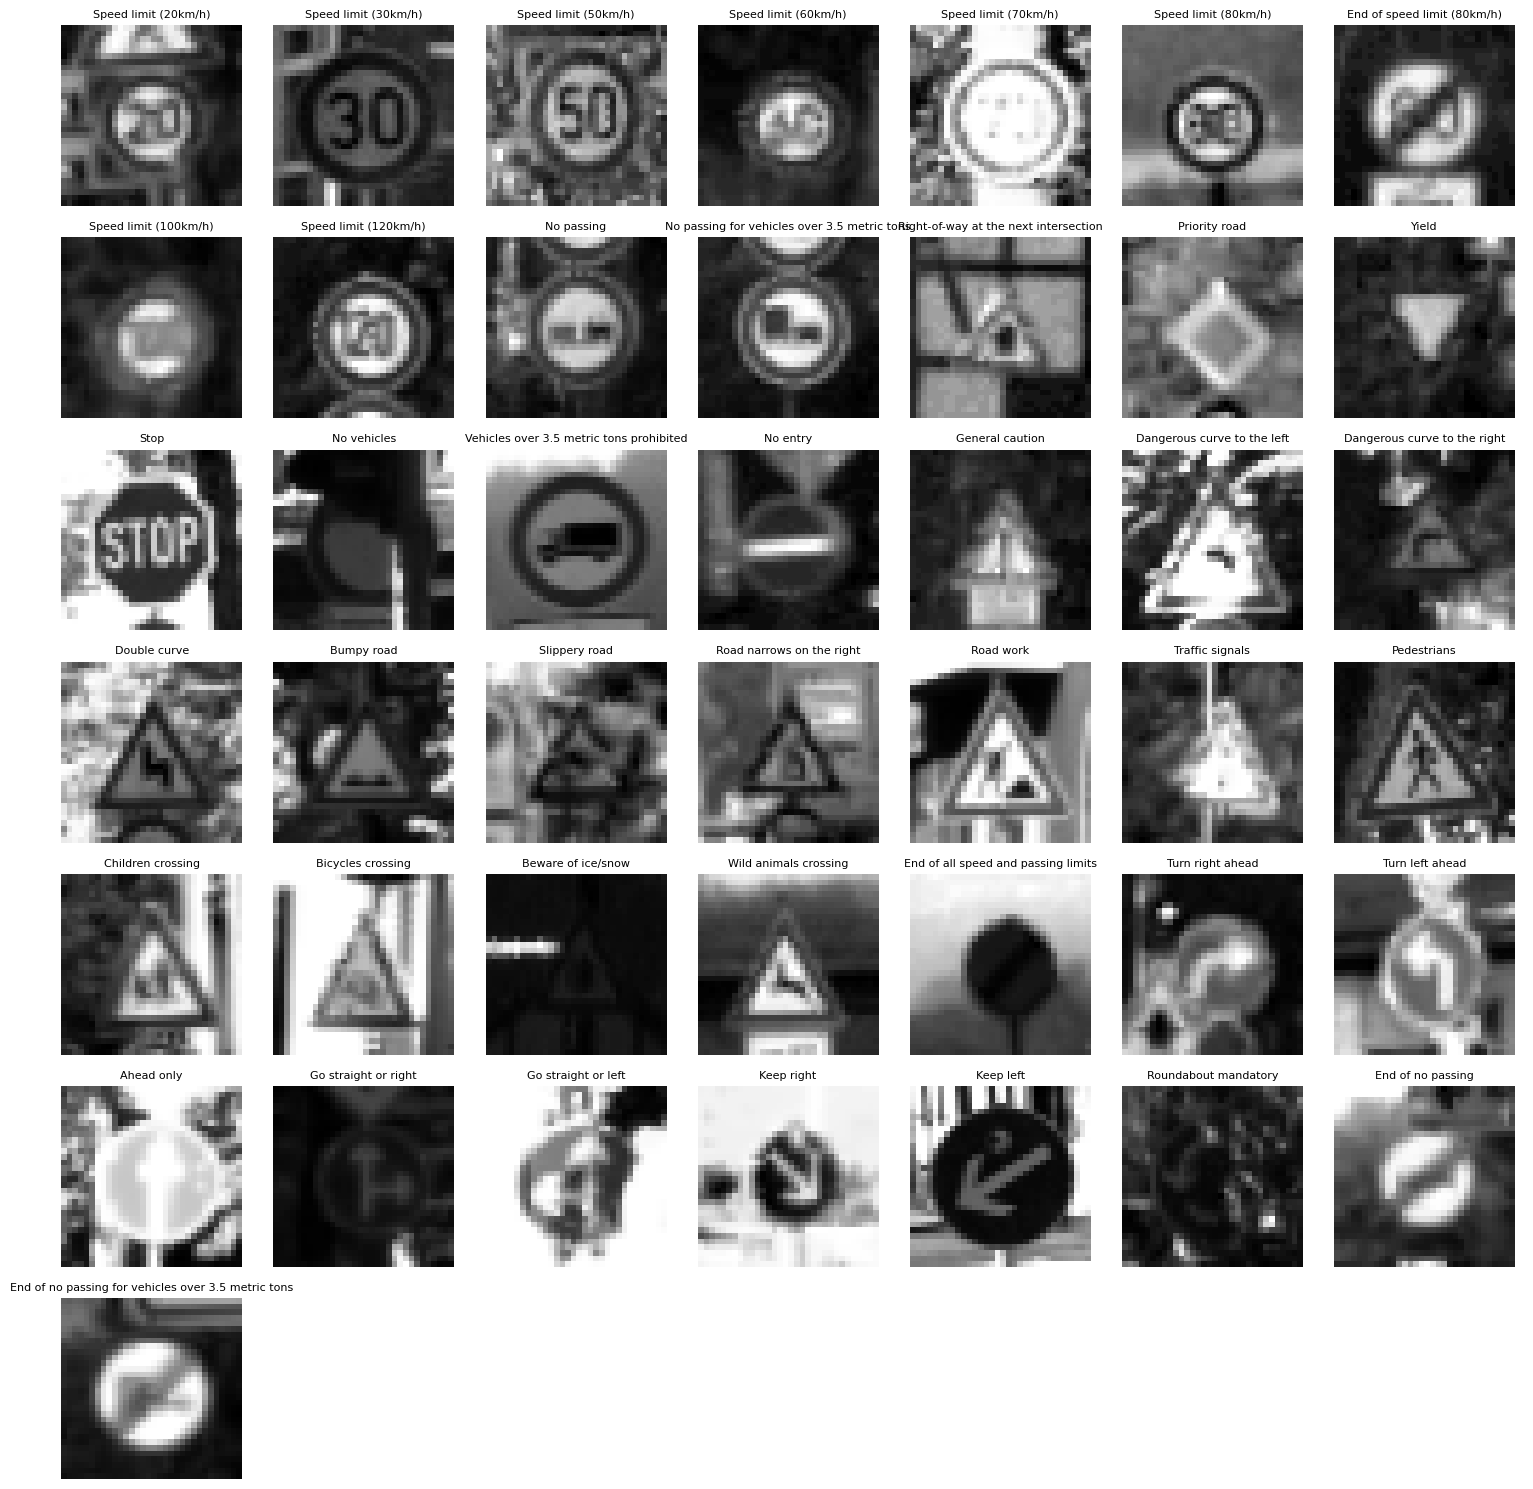

In [15]:
images_per_class = {}

#Loop through the list of labels and images (I, L) 
for image, label in zip(augmented_I_Gray, augmented_L):
                                        #Stores the first image in each class
    if label not in images_per_class:
        images_per_class[label] = image

fig, axes = plt.subplots(7, 7, figsize=(15, 15))  
axes = axes.flatten()  

#Loop through the images_per_class dictionary and plot the images
for idx, (label, image) in enumerate(images_per_class.items()):
    axes[idx].imshow(image,cmap="gray") 
    axes[idx].set_title(class_names[int(label)], fontsize=8)  
    axes[idx].axis('off')  

for i in range(len(images_per_class), len(axes)):
    axes[i].axis('off')

plt.tight_layout() 
plt.show()

Save our data

In [16]:
np.save('augmented_I_RGB.npy', augmented_I_RGB)        #RGB images
np.save('augmented_I_Gray.npy', augmented_I_Gray)      #Gray images
np.save('augmented_L.npy', augmented_L)                #Labels